# CRiCD4 Run2 - QC and exploratory analysis

In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
import os
import yaml
import scanpy as sc
import anndata as ad
import rapids_singlecell as rsc
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 300  # or 150, 200, etc.
plt.rcParams['savefig.dpi'] = 300

# Increase all font sizes
plt.rcParams['font.size'] = 16  # Base font size
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15

from preprocess import _convert_oak_path
import qc_plots
from sgrna_assignment import sgrna_assignments2adata

In [54]:
import psutil

# Get system memory information
mem_info = psutil.virtual_memory()

# Display total, available, and used memory in GB
print(f"Total memory: {mem_info.total / (1024**3):.2f} GB")
print(f"Available memory: {mem_info.available / (1024**3):.2f} GB")
print(f"Used memory: {mem_info.used / (1024**3):.2f} GB")
print(f"Memory percentage used: {mem_info.percent}%")

Total memory: 995.52 GB
Available memory: 407.31 GB
Used memory: 571.53 GB
Memory percentage used: 59.1%


In [55]:
PLOTDIR = f'../../results/CD4iR2_Psomagen/'
sc.settings.figdir = PLOTDIR
os.makedirs(PLOTDIR, exist_ok=True)

def save_plot(pl_name, plot_dir = None):
    if plot_dir is None:
        plot_dir = PLOTDIR
    plt.savefig(f'{plot_dir}/{pl_name}.pdf');
    plt.savefig(f'{plot_dir}/{pl_name}.png');

Configuration

In [56]:
# Read config
experiment_name = 'CD4iR2_Psomagen'
config_file = '../../metadata/experiments_config.yaml'
with open(config_file, 'r') as f:
    config = yaml.safe_load(f)

config = config[experiment_name]
datadir = _convert_oak_path(config['datadir'])
sample_metadata_csv = _convert_oak_path(config['sample_metadata'])

In [57]:
datadir

'/mnt/oak/users/emma/data/GWT/CD4iR2_Psomagen/'

## Summary of QC metrics

In [58]:
sample_metadata = pd.read_csv(sample_metadata_csv, index_col=0)
sgrna_library_metadata = pd.read_csv('../../metadata/sgRNA_library_curated.csv', index_col=0)

if config['lane_ids'] is not None:
    all_lanes = config['lane_ids']
all_library_ids = sample_metadata['library_id'].tolist()
all_samples = []
for library_id in all_library_ids:
    for lane_id in all_lanes:
        all_samples.append(f"{library_id}.{lane_id}")
len(all_samples)

384

In [59]:
from tqdm.notebook import tqdm
    
all_qc_summary = pd.DataFrame()
all_count_perturbs = pd.DataFrame()
for sample_id in tqdm(all_samples, desc="Processing samples"):
    try:
        qc_summary = pd.read_csv(f'{datadir}/tmp/{sample_id}.qc_summary.csv', index_col=0)
        count_perturbs = pd.read_csv(f'{datadir}/tmp/{sample_id}.perturbation_counts.csv', index_col=0)
        all_qc_summary = pd.concat([all_qc_summary, qc_summary])
        all_count_perturbs = pd.concat([all_count_perturbs, count_perturbs])
    except:
        continue
        
all_count_perturbs = all_count_perturbs.pivot(index='guide_id', columns='sample_id', values='n_cells').fillna(0)

Processing samples:   0%|          | 0/384 [00:00<?, ?it/s]

In [60]:
all_qc_summary.to_csv(f'{datadir}/QC_summary_stats.csv')
all_count_perturbs.to_csv(f'{datadir}/perturbation_counts.csv')

In [61]:
all_qc_summary = pd.read_csv(f'{datadir}/QC_summary_stats.csv', index_col=0)
all_count_perturbs = pd.read_csv(f'{datadir}/perturbation_counts.csv', index_col=0)

In [62]:
all_qc_summary.head()

,library_id,lane_id,mean_total_counts,mean_n_genes,mean_pct_counts_mt,mean_top_guide_UMI_counts,n_cells,n_low_quality_cells,NTC single sgRNA,multi sgRNA,no sgRNA (>= 3 UMIs),targeting single sgRNA,n_unique_guides,n_unique_perturbed_genes,mean_cells_x_guide,mean_cells_x_perturbed_gene
0,CD4i_R2_D3_Rest_CD4i_R2_Ultima,CD4i_R2L01,13285.634,4187.814500,0.573849,150.328896,113914,443,3219,23860,11295,75097,14076,9634,5.563797,8.129126
0,CD4i_R2_D3_Rest_CD4i_R2_Ultima,CD4i_R2L02,16580.342,4556.615607,0.599576,141.191995,88433,409,2446,17097,10388,58093,12508,8882,4.840022,6.815920
0,CD4i_R2_D3_Rest_CD4i_R2_Ultima,CD4i_R2L03,13797.838,4212.409915,0.592349,143.489722,89504,397,2457,16912,10338,59400,12608,8951,4.906171,6.910625
0,CD4i_R2_D3_Rest_CD4i_R2_Ultima,CD4i_R2L04,15891.131,4525.213117,0.584216,146.301763,88740,452,2381,17277,10218,58412,12691,8984,4.790245,6.766808
0,CD4i_R2_D3_Rest_CD4i_R2_Ultima,CD4i_R2L05,15209.561,4435.575832,0.579576,150.594691,107521,490,3000,23255,10664,70112,13801,9511,5.297587,7.687099


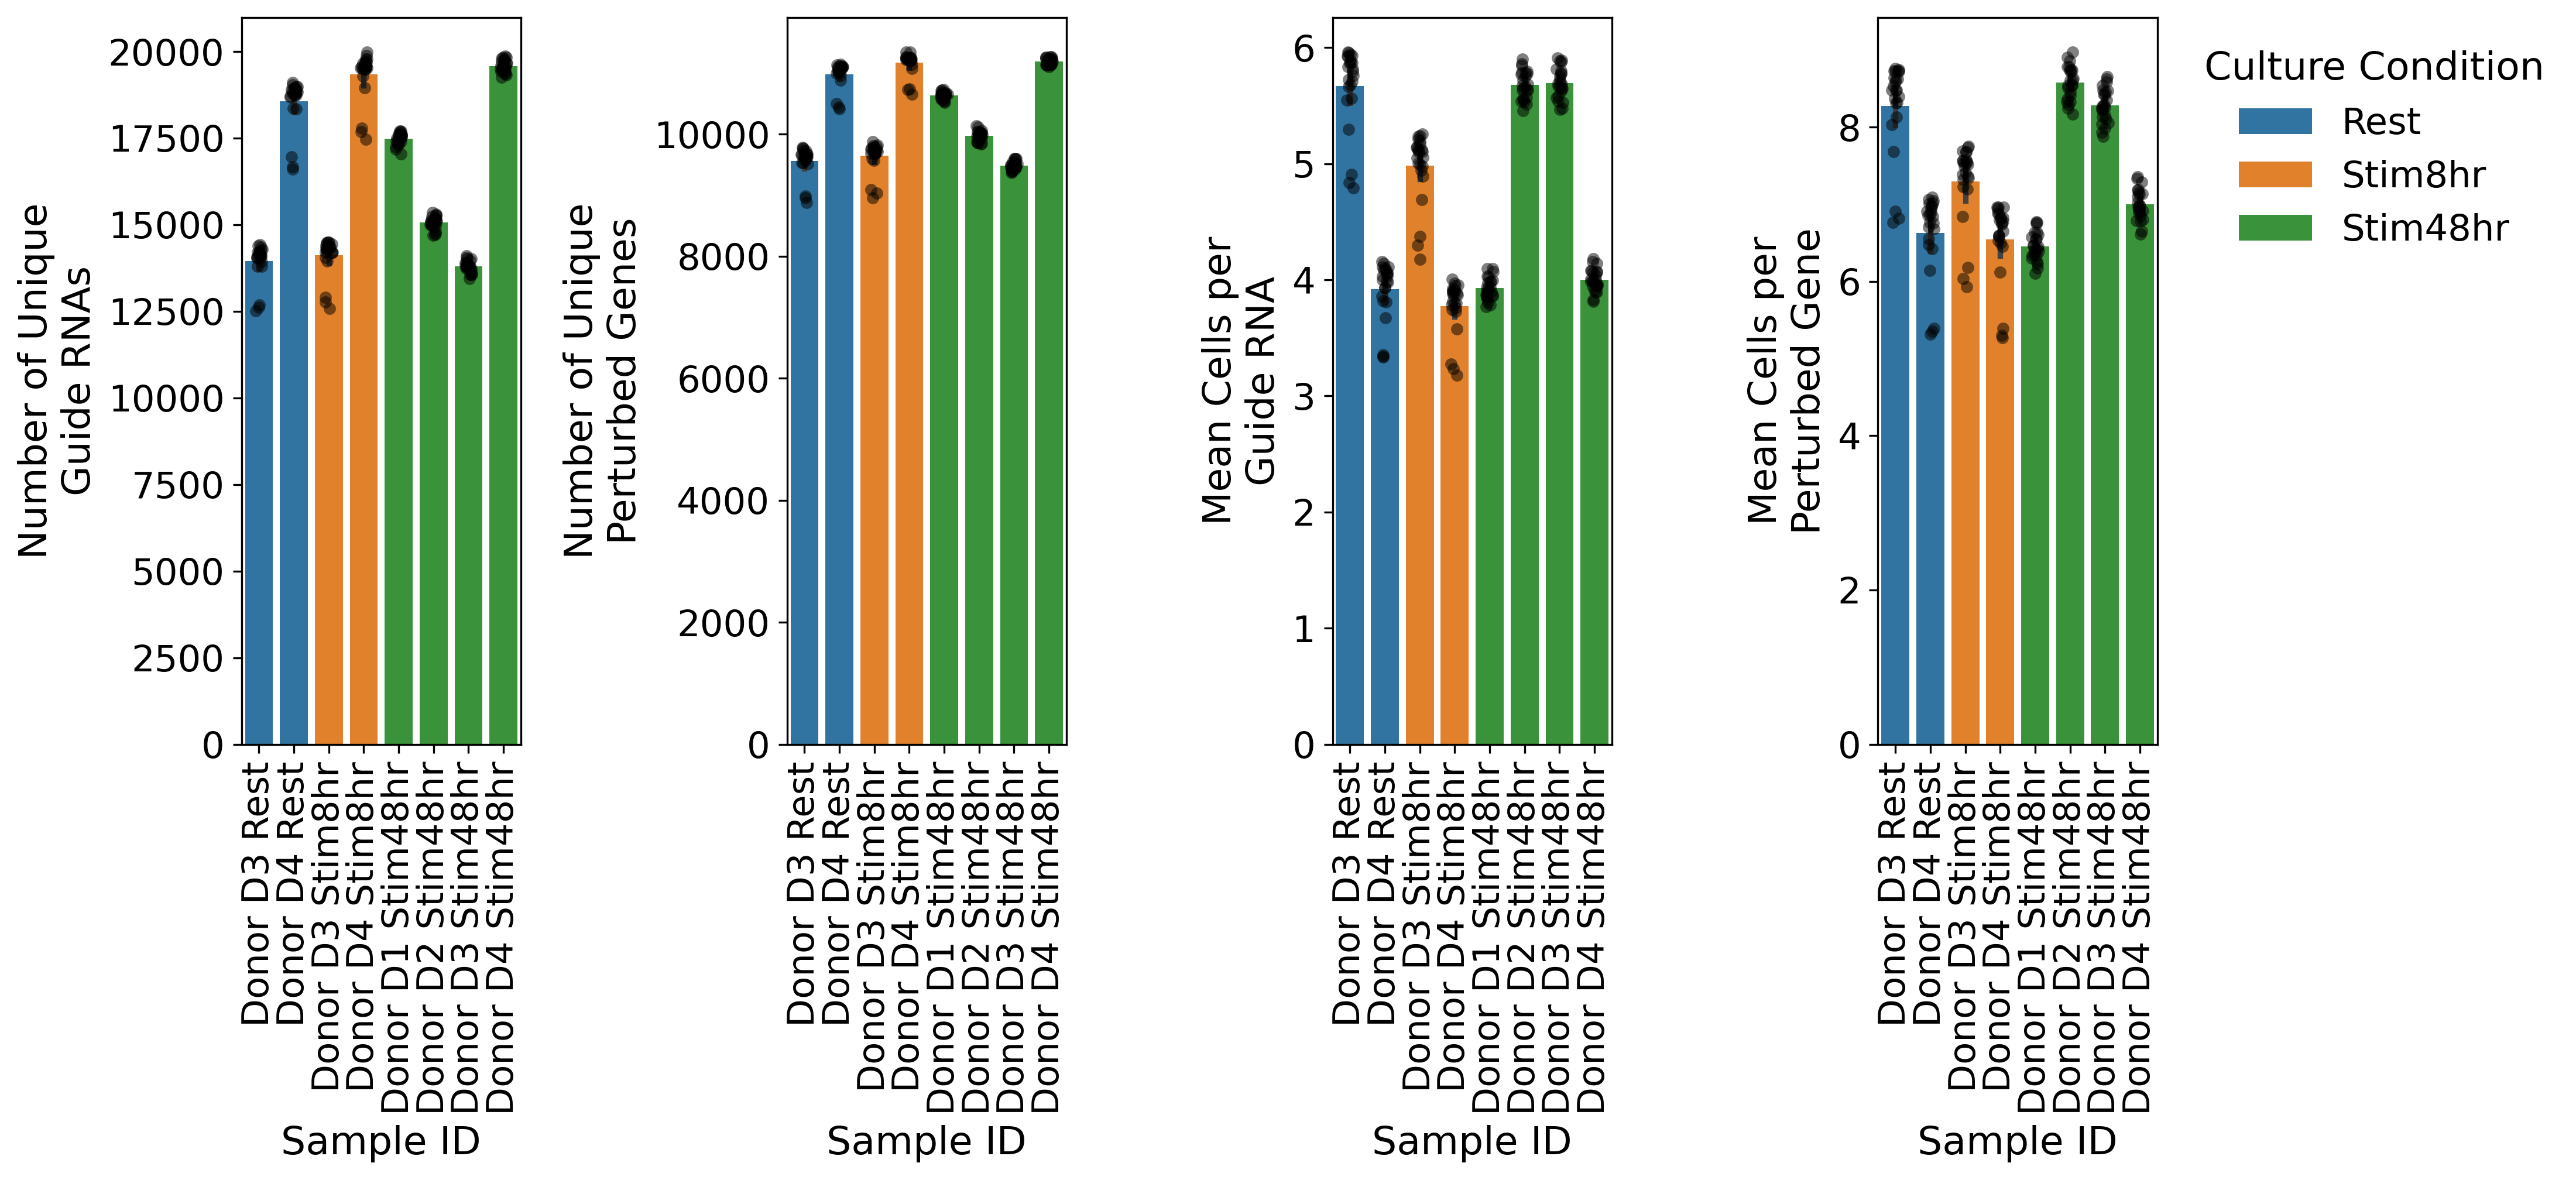

In [63]:
pl_cols = ['n_unique_guides',
       'n_unique_perturbed_genes', 'mean_cells_x_guide',
       'mean_cells_x_perturbed_gene'
       ]

# Define better y-axis labels
y_labels = {
    'n_unique_guides': 'Number of Unique\nGuide RNAs',
    'n_unique_perturbed_genes': 'Number of Unique\nPerturbed Genes',
    'mean_cells_x_guide': 'Mean Cells per\nGuide RNA',
    'mean_cells_x_perturbed_gene': 'Mean Cells per\nPerturbed Gene'
}

all_qc_summary['donor_id'] = all_qc_summary['library_id'].str.split('_').str[2]
all_qc_summary['culture_condition'] = all_qc_summary['library_id'].str.split('_').str[3]
all_qc_summary['sample_id'] = 'Donor ' + all_qc_summary['donor_id'] + ' ' + all_qc_summary['culture_condition']

# Create subplots for each metric in one row
n_cols = len(pl_cols)
fig, axes = plt.subplots(1, n_cols, figsize=(15, 7))

for idx, col in enumerate(pl_cols):
    sns.barplot(data=all_qc_summary, x='sample_id', y=col, hue='culture_condition', ax=axes[idx])
    sns.stripplot(data=all_qc_summary, x='sample_id', y=col, color='black', 
                 size=5, alpha=0.5, 
                 legend=False, ax=axes[idx])
    
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=90)
    axes[idx].set_xlabel('Sample ID')
    axes[idx].set_ylabel(y_labels[col])
    
    # Only show legend on first plot
    if idx != 3:
        axes[idx].get_legend().remove()
    else:
        axes[idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
                        title='Culture Condition', frameon=False)

plt.tight_layout()

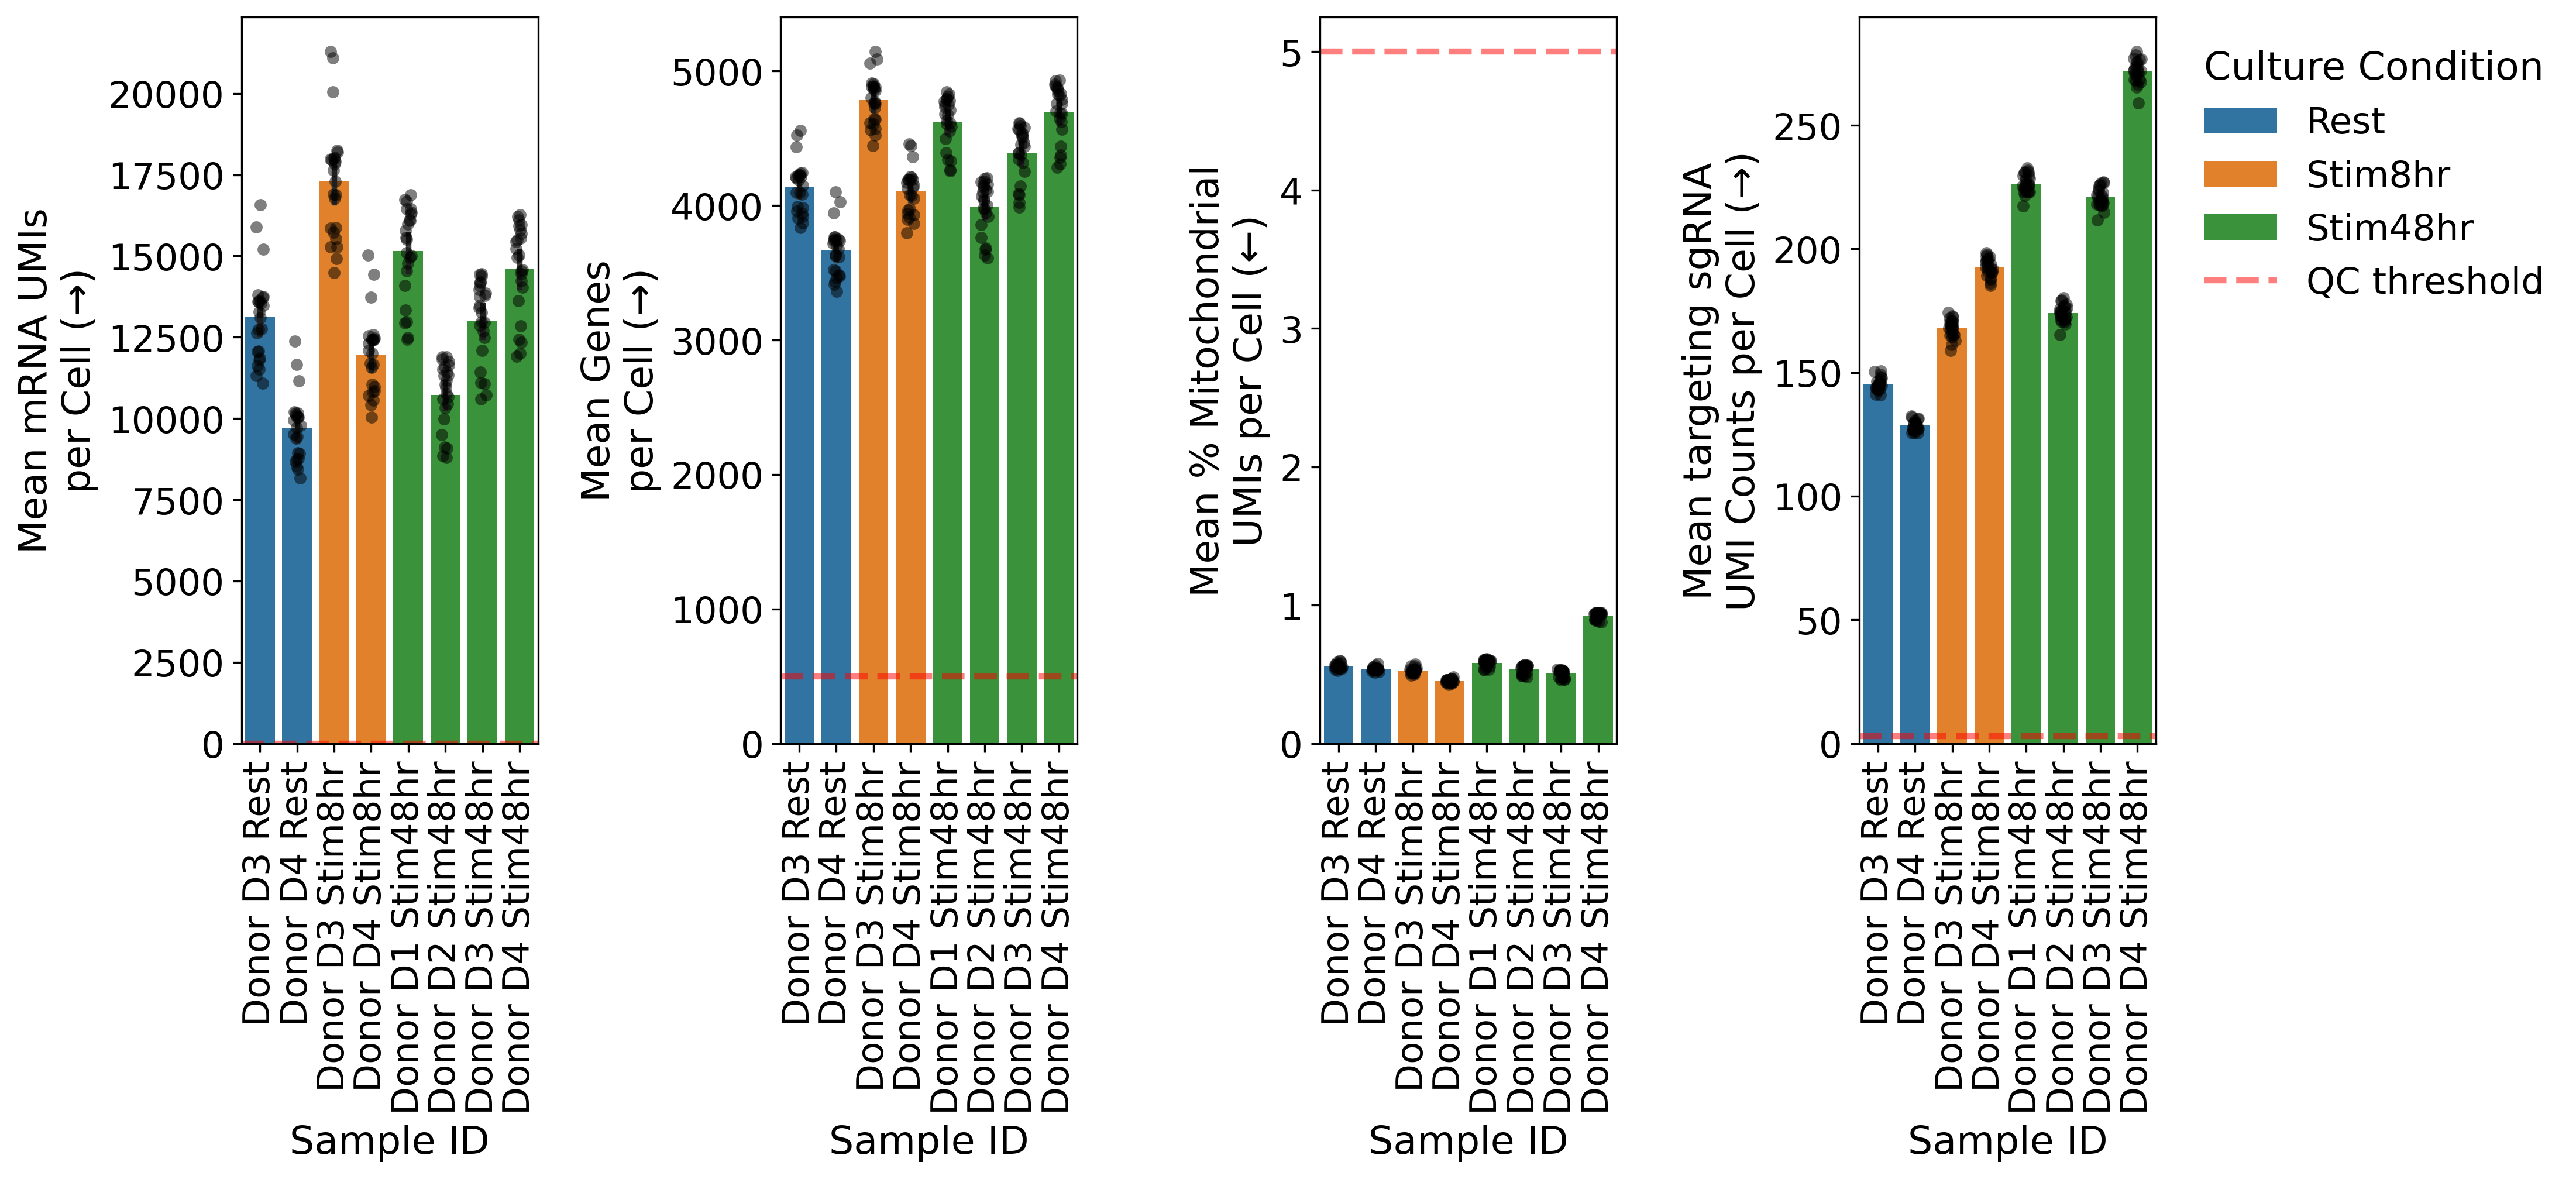

In [64]:
pl_cols = ['mean_total_counts', 'mean_n_genes',
       'mean_pct_counts_mt', 'mean_top_guide_UMI_counts'
       ]

qc_thresholds = {
    'mean_total_counts':0,
    'mean_n_genes':500,
    'mean_pct_counts_mt':5,
    'mean_top_guide_UMI_counts':3   
}

# Define better y-axis labels
y_labels = {
    'mean_total_counts': 'Mean mRNA UMIs\nper Cell (→)',  # Higher is better
    'mean_n_genes': 'Mean Genes\nper Cell (→)',  # Higher is better
    'mean_pct_counts_mt': 'Mean % Mitochondrial\nUMIs per Cell (←)',  # Lower is better
    'mean_top_guide_UMI_counts': 'Mean targeting sgRNA\nUMI Counts per Cell (→)'  # Higher is better
}

all_qc_summary['donor_id'] = all_qc_summary['library_id'].str.split('_').str[2]
all_qc_summary['culture_condition'] = all_qc_summary['library_id'].str.split('_').str[3]
all_qc_summary['sample_id'] = 'Donor ' + all_qc_summary['donor_id'] + ' ' + all_qc_summary['culture_condition']

# Create subplots for each metric in one row
n_cols = len(pl_cols)
fig, axes = plt.subplots(1, n_cols, figsize=(15, 7))

for idx, col in enumerate(pl_cols):
    sns.barplot(data=all_qc_summary, x='sample_id', y=col, hue='culture_condition', ax=axes[idx])
    sns.stripplot(data=all_qc_summary, x='sample_id', y=col, color='black', 
                 size=5, alpha=0.5, 
                 legend=False, ax=axes[idx])
    
    # Add horizontal dotted line for QC threshold
    threshold = qc_thresholds[col]
    axes[idx].axhline(y=threshold, color='red', linestyle='--', alpha=0.5, 
                     label=f'QC threshold', linewidth=2.5)
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=90)
    axes[idx].set_xlabel('Sample ID')
    axes[idx].set_ylabel(y_labels[col])
    
    # Only show legend on first plot
    if idx != 3:
        axes[idx].get_legend().remove()
    else:
        axes[idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
                        title='Culture Condition', frameon=False)

plt.tight_layout()

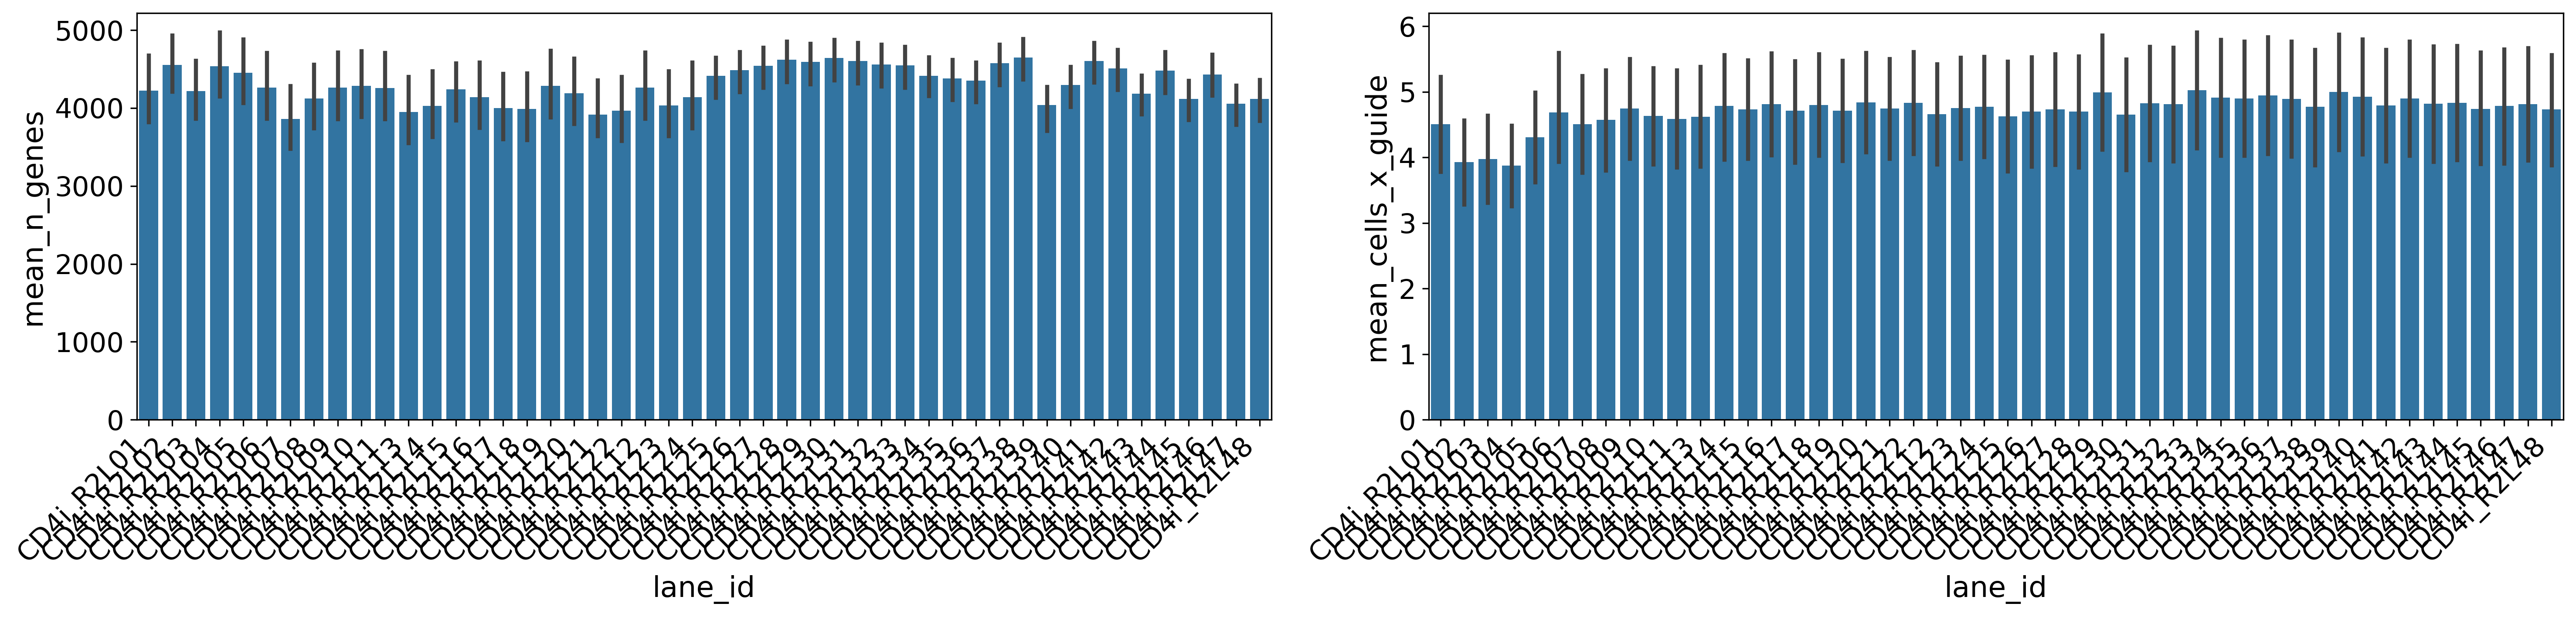

In [65]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5))

sns.barplot(all_qc_summary, x='lane_id', y='mean_n_genes', ax=ax1)
# sns.stripplot(all_qc_summary, x='lane_id', y='mean_n_genes', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

sns.barplot(all_qc_summary, x='lane_id', y='mean_cells_x_guide', ax=ax2)
# sns.stripplot(all_qc_summary, x='lane_id', y='mean_cells_x_guide', ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()

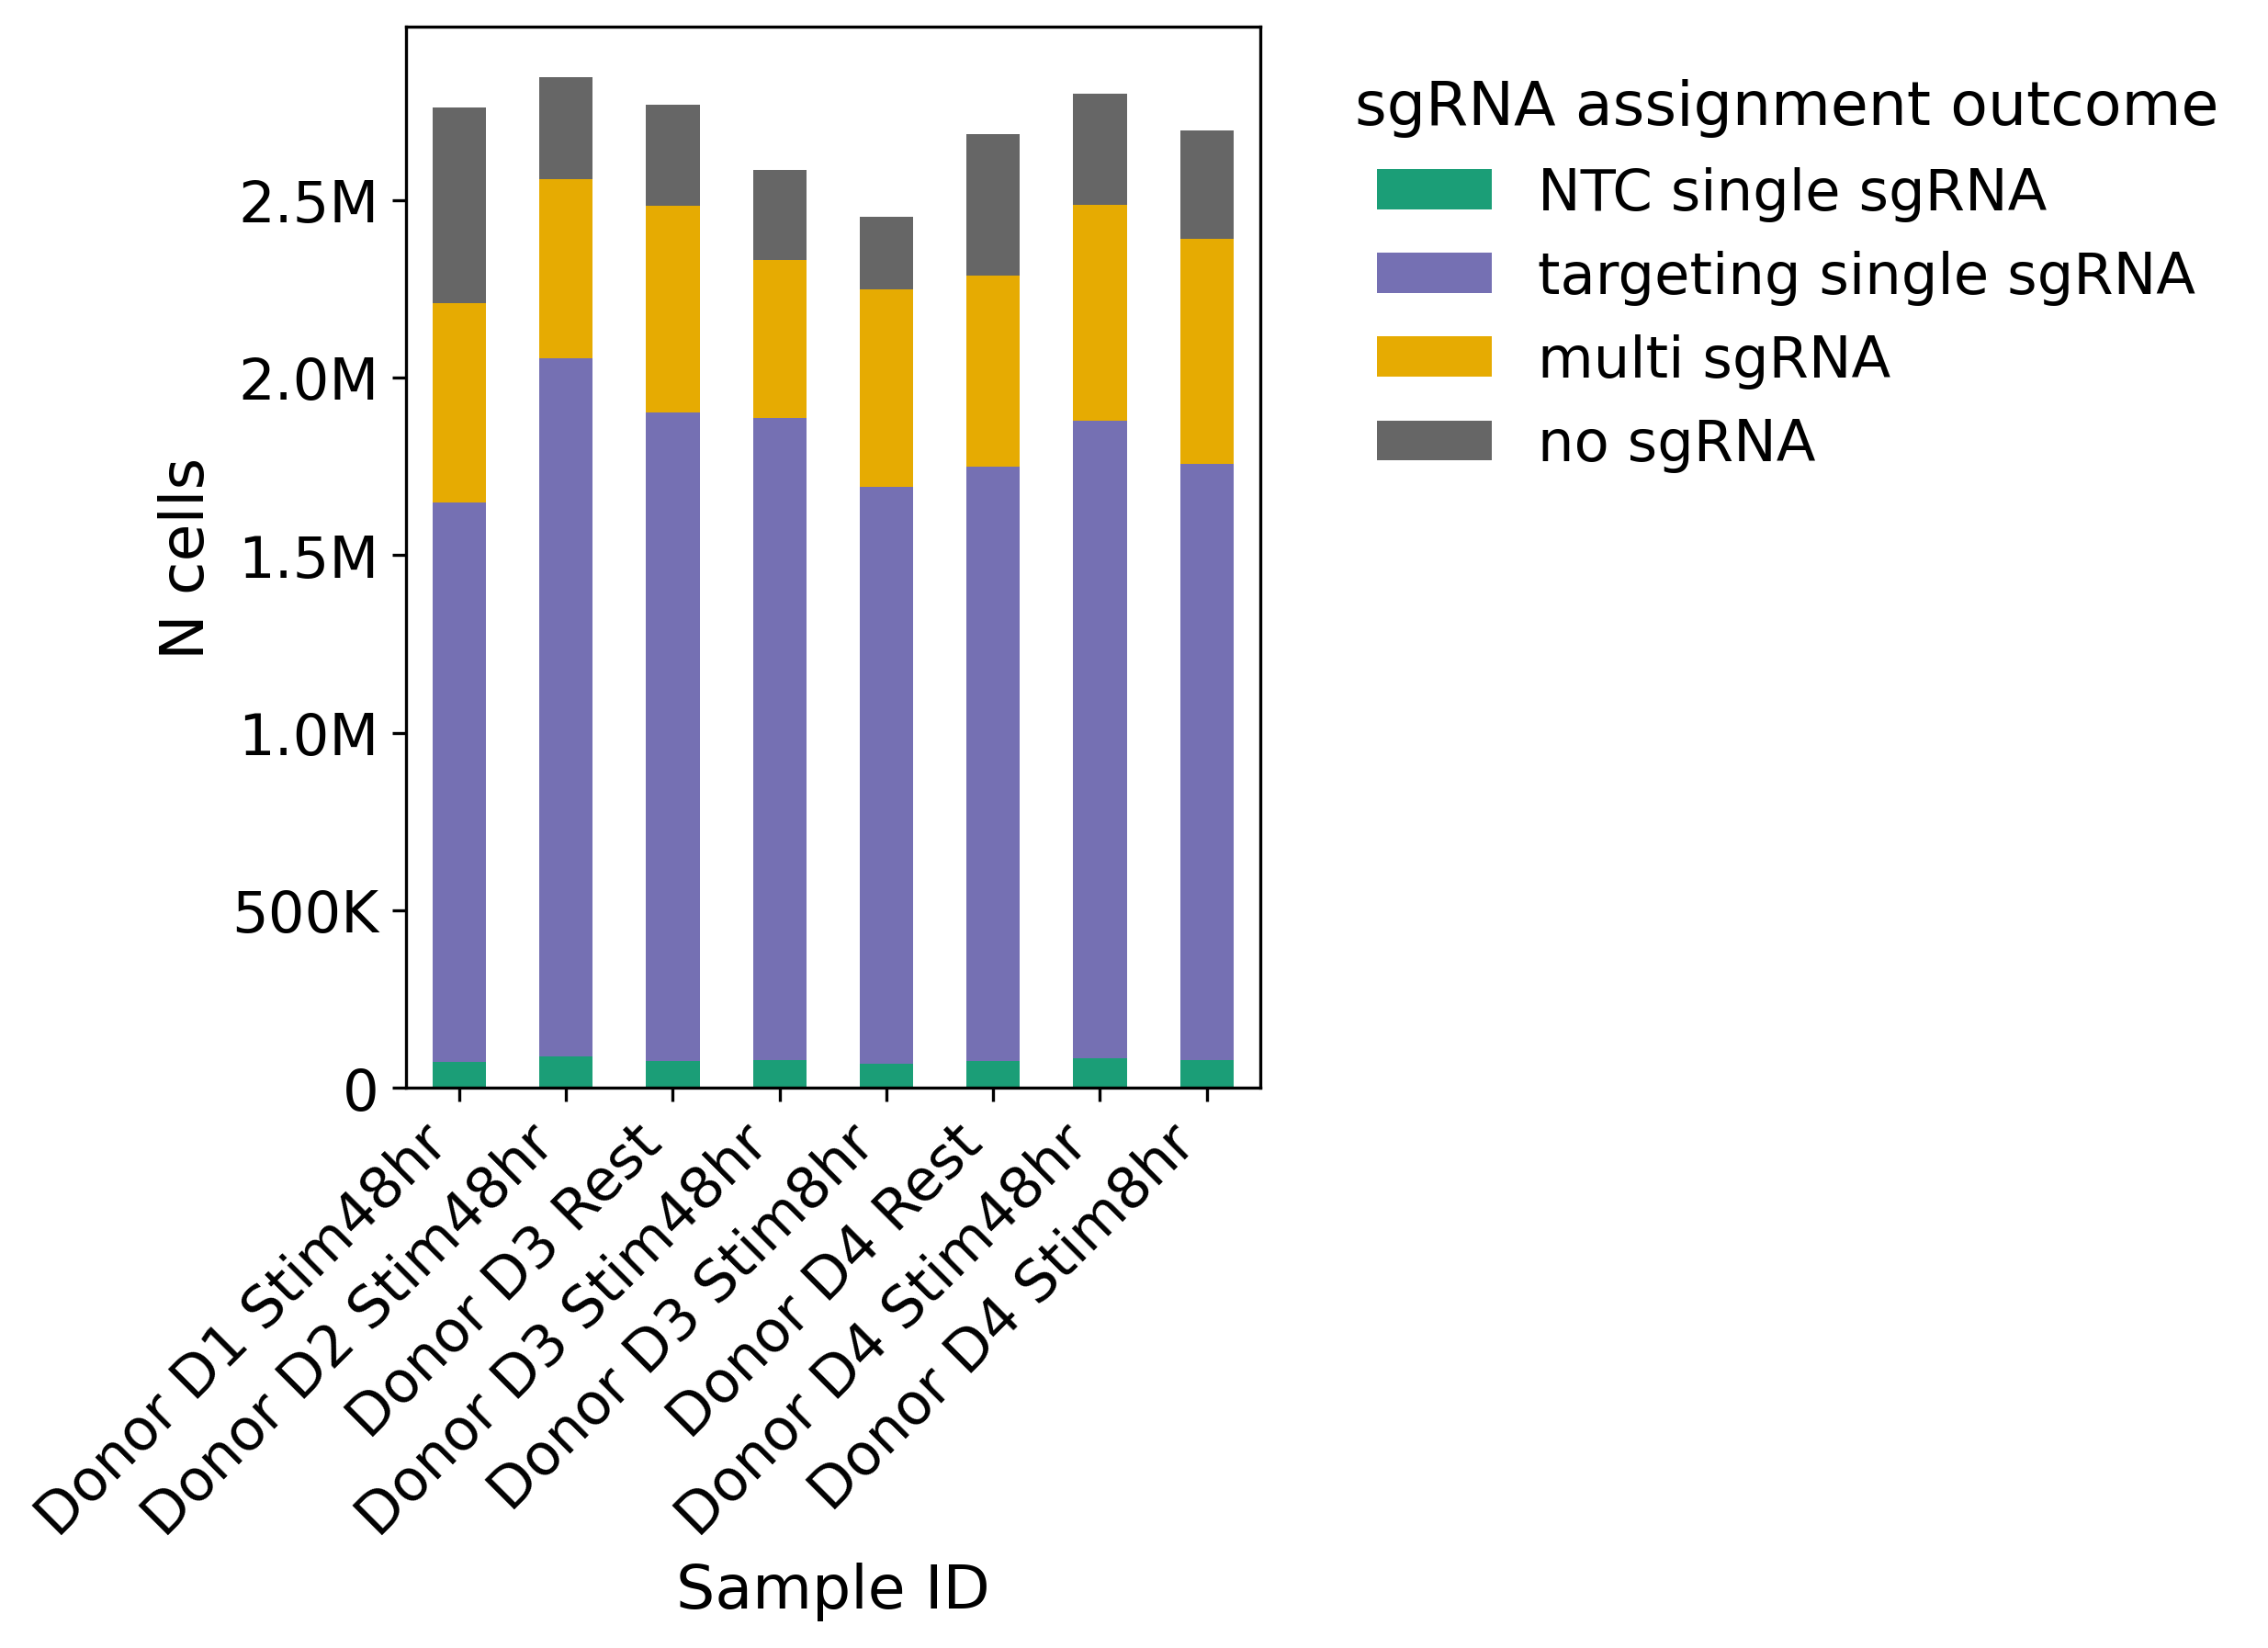

In [66]:
pl_df = all_qc_summary.groupby('sample_id').sum()
# Define the order for the groups
group_order = ['NTC single sgRNA', 'targeting single sgRNA', 'multi sgRNA', 'no sgRNA (>= 3 UMIs)']
group_counts = pl_df[group_order]
group_counts = group_counts.rename({'no sgRNA (>= 3 UMIs)':'no sgRNA'}, axis=1)
# group_fractions = group_counts.div(group_counts.sum(axis=1), axis=0)
ax = group_counts.plot(kind='bar', stacked=True, figsize=(4,5), colormap='Dark2')
plt.xticks(rotation=45, ha='right')
plt.ylabel('N cells')
plt.xlabel('Sample ID')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='sgRNA assignment outcome', frameon=False)
# Format y-axis to use M notation for millions
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{int(x/1e3)}K' if x >= 1e3 else int(x)))

# ax.ticklabel_format(useOffset=False)
plt.tight_layout()

### Number of cells per perturbation

In [18]:
# Download and read the Core Essential and non-essential gene list (as used in GeneBayes paper)
ceg_url = "https://raw.githubusercontent.com/macarthur-lab/gene_lists/master/lists/CEGv2_subset_universe.tsv"
neg_url = 'https://raw.githubusercontent.com/macarthur-lab/gene_lists/refs/heads/master/lists/NEGv1_subset_universe.tsv'
core_essential = pd.read_csv(ceg_url, sep='\t', header=None)[0].tolist()
core_nonessential = pd.read_csv(neg_url, sep='\t', header=None)[0].tolist()

## Load IL2 hits
schmidt_crispri = pd.read_excel('../../metadata/Schmidt2022_hits_Supplementary_table_2.xlsx', usecols=range(10))
schmidt_crispri_hits = schmidt_crispri[schmidt_crispri['Hit'] & (schmidt_crispri['CRISPRa_or_i'] == 'CRISPRi') & (schmidt_crispri['CD4_or_CD8'] == 'CD4')]

# Create dictionary where key is hit type and values are lists of genes
hit_type_dict = {}
for hit_type in schmidt_crispri_hits['Hit_Type'].unique():
    hit_type_dict[hit_type] = schmidt_crispri_hits[schmidt_crispri_hits['Hit_Type'] == hit_type]['Gene'].tolist()


In [19]:
pl_df = all_count_perturbs.reset_index().melt(id_vars='guide_id', var_name='library_id', value_name='n_cells')
pl_df = pd.merge(
    sgrna_library_metadata[['sgrna_id', 'perturbed_gene_name']].rename({'sgrna_id':'guide_id'}, axis=1),
    pl_df
)
pl_df['sample_id'] = pl_df.library_id.str.split('.').str[0]
pl_df['culture_condition'] = pl_df['sample_id'].str.split('_').str[3]

n_cells_count_df = pl_df.groupby(['perturbed_gene_name','culture_condition'])['n_cells'].sum().reset_index()


In [20]:
n_cells_count_df.groupby('culture_condition')['n_cells'].mean()

culture_condition
Rest        261.597672
Stim48hr    587.191570
Stim8hr     247.063778
Name: n_cells, dtype: float64

In [21]:
n_cells_count_df['Schmidt_hits'] = np.nan
n_cells_count_df['Schmidt_hits'] = np.where(n_cells_count_df.perturbed_gene_name.isin(hit_type_dict['Positive Hit']), 'IL2_pos_hit', n_cells_count_df['Schmidt_hits'])
n_cells_count_df['Schmidt_hits'] = np.where(n_cells_count_df.perturbed_gene_name.isin(hit_type_dict['Negative Hit']), 'IL2_neg_hit', n_cells_count_df['Schmidt_hits'])

n_cells_count_df['essential_genes'] = np.nan
n_cells_count_df['essential_genes'] = np.where(n_cells_count_df.perturbed_gene_name.isin(core_essential), 'gold standard essential', n_cells_count_df['essential_genes'])
n_cells_count_df['essential_genes'] = np.where(n_cells_count_df.perturbed_gene_name.isin(core_nonessential), 'gold standard non-essential', n_cells_count_df['essential_genes'])


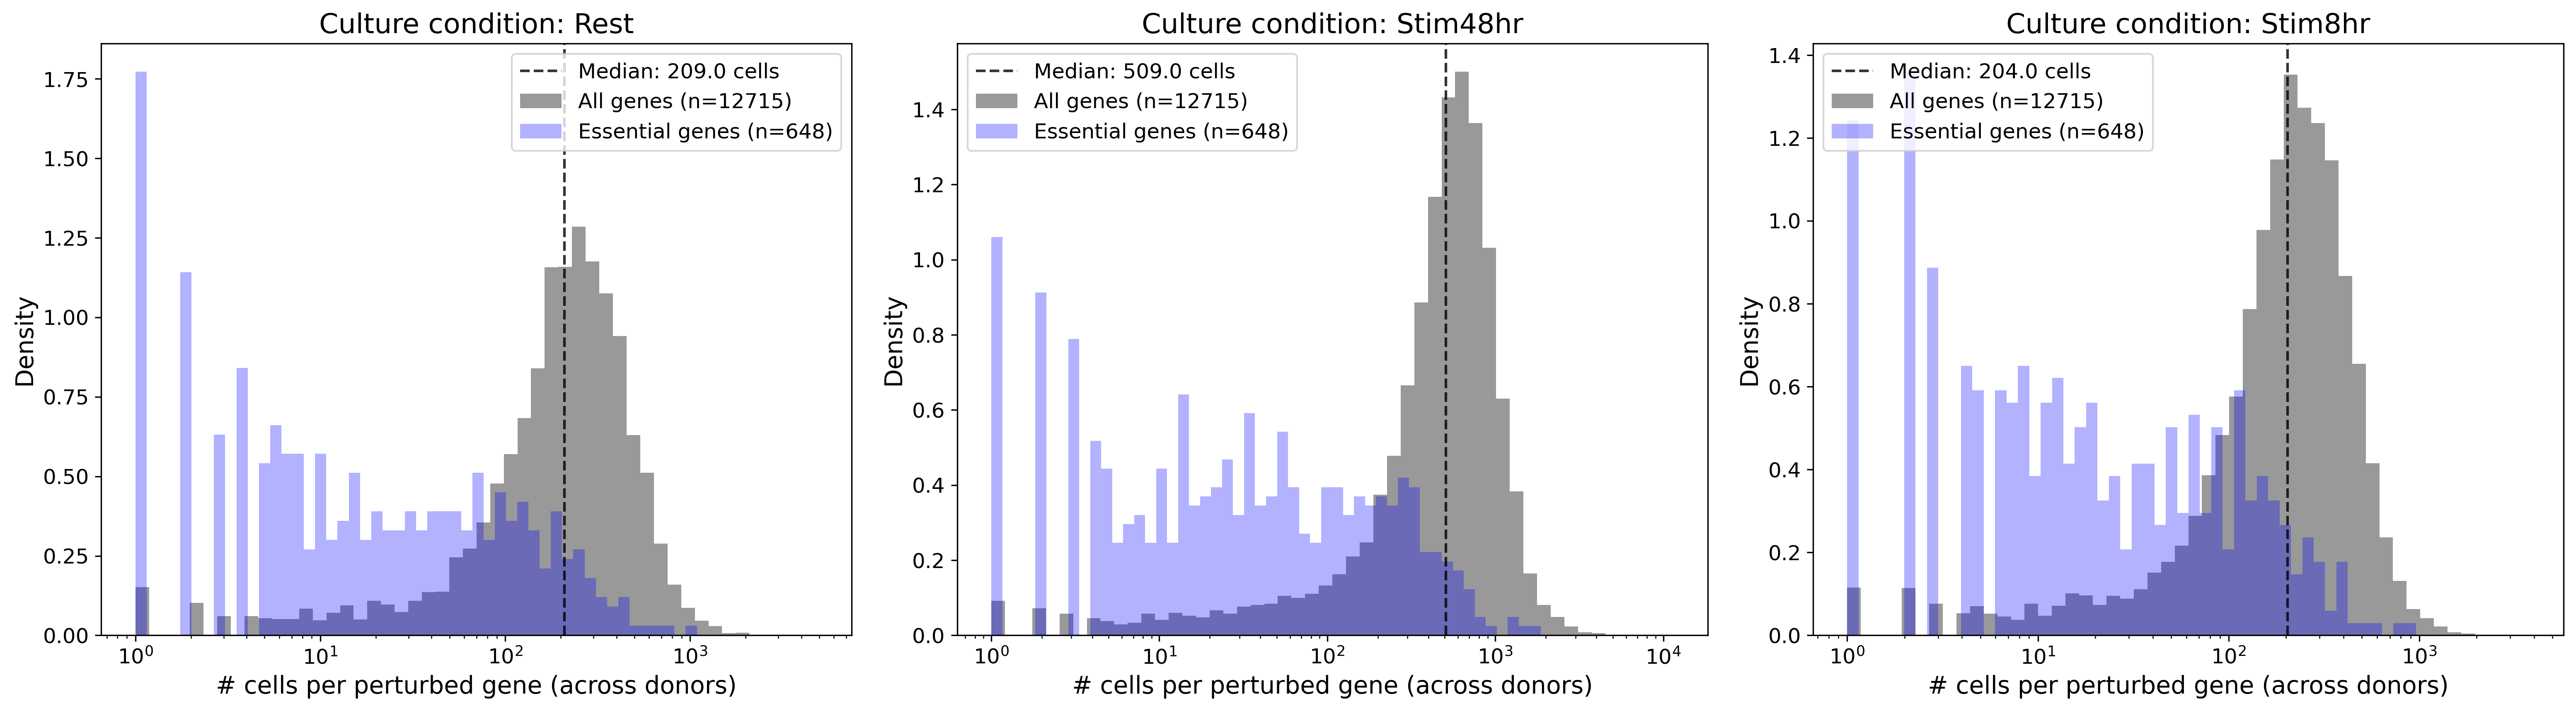

In [22]:
# Create histogram with density lines comparing IL2_neg_hit genes and essential genes with all genes
essential_df = n_cells_count_df[n_cells_count_df['essential_genes'] == 'gold standard essential']
all_genes_df = n_cells_count_df[n_cells_count_df.perturbed_gene_name != 'NTC']  # All genes except NTC

# Get unique conditions
conditions = all_genes_df['culture_condition'].unique()
n_conditions = len(conditions)

# Create figure with subplots - one per condition
fig, axes = plt.subplots(1, n_conditions, figsize=(7*n_conditions, 6))

# Plot for each condition
for i, condition in enumerate(conditions):
    condition_all = all_genes_df[all_genes_df['culture_condition'] == condition]
    condition_essential = essential_df[essential_df['culture_condition'] == condition]

    # Get unique gene counts for legend
    n_all = len(condition_all['perturbed_gene_name'].unique())
    n_essential = len(condition_essential['perturbed_gene_name'].unique())

    # Plot histogram for all genes
    sns.histplot(data=condition_all, x='n_cells', bins=50,
                stat='density', common_norm=False, log_scale=True,
                color='gray', alpha=0.8, label=f'All genes (n={n_all})', kde=True, ax=axes[i],
                edgecolor='none')

    # Add vertical line for median
    axes[i].axvline(x=condition_all['n_cells'].median(), color='black', alpha=0.8, linestyle='--',
                    label=f'Median: {condition_all["n_cells"].median():.1f} cells')

    # Plot histogram for essential genes
    sns.histplot(data=condition_essential, x='n_cells', bins=50,
                stat='density', common_norm=False, log_scale=True,
                color='blue', alpha=0.3, ax=axes[i], label=f'Essential genes (n={n_essential})',
                edgecolor='none')

    # Customize plot
    axes[i].set_title(f'Culture condition: {condition}', fontsize=16)
    axes[i].legend(fontsize=12)
    axes[i].set_xlabel('# cells per perturbed gene (across donors)', fontsize=14)
    axes[i].set_ylabel('Density', fontsize=14)
    axes[i].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()


Check tail of distribution that are not in IL2 regulators or essential genes

In [21]:
n_cells_count_df[
    (n_cells_count_df.culture_condition == 'Rest') & 
    (n_cells_count_df['n_cells'] == 0) &
    (n_cells_count_df['Schmidt_hits'] == 'nan') &
    (n_cells_count_df['essential_genes'] == 'nan')
]['perturbed_gene_name'].tolist()

['AAMP',
 'AARS2',
 'ABAT',
 'ABCA3',
 'ABCB10',
 'ABCD1',
 'ABCD2',
 'ABHD15',
 'ABT1',
 'ACBD4',
 'ACE',
 'ACSL5',
 'ACTR3B',
 'ACTR6',
 'ADAM10',
 'ADAMTSL5',
 'ADAR',
 'AFDN',
 'AGBL5',
 'AGER',
 'AGO2',
 'AGO4',
 'AHCTF1',
 'AIDA',
 'AK2',
 'AKIP1',
 'ALAS1',
 'ALDH6A1',
 'ALDOA',
 'ALG10',
 'ALKBH3',
 'ALPL',
 'ALYREF',
 'AMMECR1L',
 'ANKAR',
 'ANKRA2',
 'ANKRD42',
 'ANLN',
 'AP1S1',
 'AP2A2',
 'AP2M1',
 'AP5M1',
 'APAF1',
 'APRT',
 'ARHGAP6',
 'ARHGEF10',
 'ARMC7',
 'ARRDC5',
 'ASB7',
 'ATF5',
 'ATG7',
 'ATIC',
 'ATP11B',
 'ATP6V0D1',
 'ATP6V1B2',
 'ATP6V1G1',
 'ATRAID',
 'AXIN1',
 'BAG2',
 'BAP1',
 'BBIP1',
 'BCL11B',
 'BCL2L2',
 'BCL7B',
 'BHLHB9',
 'BMI1',
 'BMPR2',
 'BRCA2',
 'BRI3',
 'BTBD9',
 'BTN2A2',
 'C16orf87',
 'C19orf25',
 'C1orf131',
 'C1orf162',
 'C1orf56',
 'C2CD2L',
 'C3AR1',
 'C3orf58',
 'C5',
 'CABP4',
 'CALM2',
 'CAMLG',
 'CAPZB',
 'CARMIL1',
 'CARS',
 'CASD1',
 'CASP8',
 'CAVIN1',
 'CBLL1',
 'CCAR1',
 'CCDC12',
 'CCDC28A',
 'CCDC65',
 'CCDC82',
 'CCDC88B',
 '

In [32]:
n_cells_count_df[
    (n_cells_count_df.culture_condition == 'Stim8hr') & 
    (n_cells_count_df['n_cells'] == 0) &
    (n_cells_count_df['Schmidt_hits'] == 'nan') &
    (n_cells_count_df['essential_genes'] == 'nan')
]['perturbed_gene_name'].tolist()

['AAMP',
 'ABCB10',
 'ACBD4',
 'ACE',
 'ACSL5',
 'ACTR3B',
 'ACTR6',
 'ADAMTSL5',
 'ADAR',
 'AFDN',
 'AGO4',
 'AHCTF1',
 'AHNAK',
 'AKIP1',
 'ALDH6A1',
 'ALKBH3',
 'ALYREF',
 'AMMECR1L',
 'ANAPC1',
 'ANKAR',
 'ANLN',
 'AP1S1',
 'AP5M1',
 'APOD',
 'ARHGEF10',
 'ARMC7',
 'ARRDC5',
 'ATAD3B',
 'ATF5',
 'ATIC',
 'ATP13A2',
 'ATP6V1B2',
 'ATP6V1C1',
 'ATP6V1F',
 'ATP6V1G1',
 'ATRAID',
 'AXIN1',
 'AZI2',
 'BAG2',
 'BHLHB9',
 'BOD1L1',
 'BTF3',
 'BTN2A2',
 'C1orf131',
 'C1orf162',
 'C1orf56',
 'C5',
 'CABP4',
 'CAMLG',
 'CAPZB',
 'CARS',
 'CCDC154',
 'CCDC86',
 'CDAN1',
 'CDC26',
 'CDC42EP5',
 'CDC6',
 'CDCA5',
 'CDK12',
 'CDKN2C',
 'CENPH',
 'CENPL',
 'CENPU',
 'CENPW',
 'CEP72',
 'CEP85',
 'CEP95',
 'CERS5',
 'CFDP1',
 'CHD6',
 'CHD9',
 'CHTF18',
 'CIAPIN1',
 'CLSPN',
 'CMTM7',
 'CMTR2',
 'CNOT2',
 'CNOT7',
 'CNPY4',
 'COG1',
 'COG2',
 'COG4',
 'COG8',
 'COPS2',
 'COX19',
 'CPA5',
 'CPT1B',
 'CPTP',
 'CREB3L4',
 'CRK',
 'CSNK1A1',
 'CSRNP3',
 'CSTF1',
 'CUL1',
 'CUL2',
 'CWC22',
 'CXCR4',
 

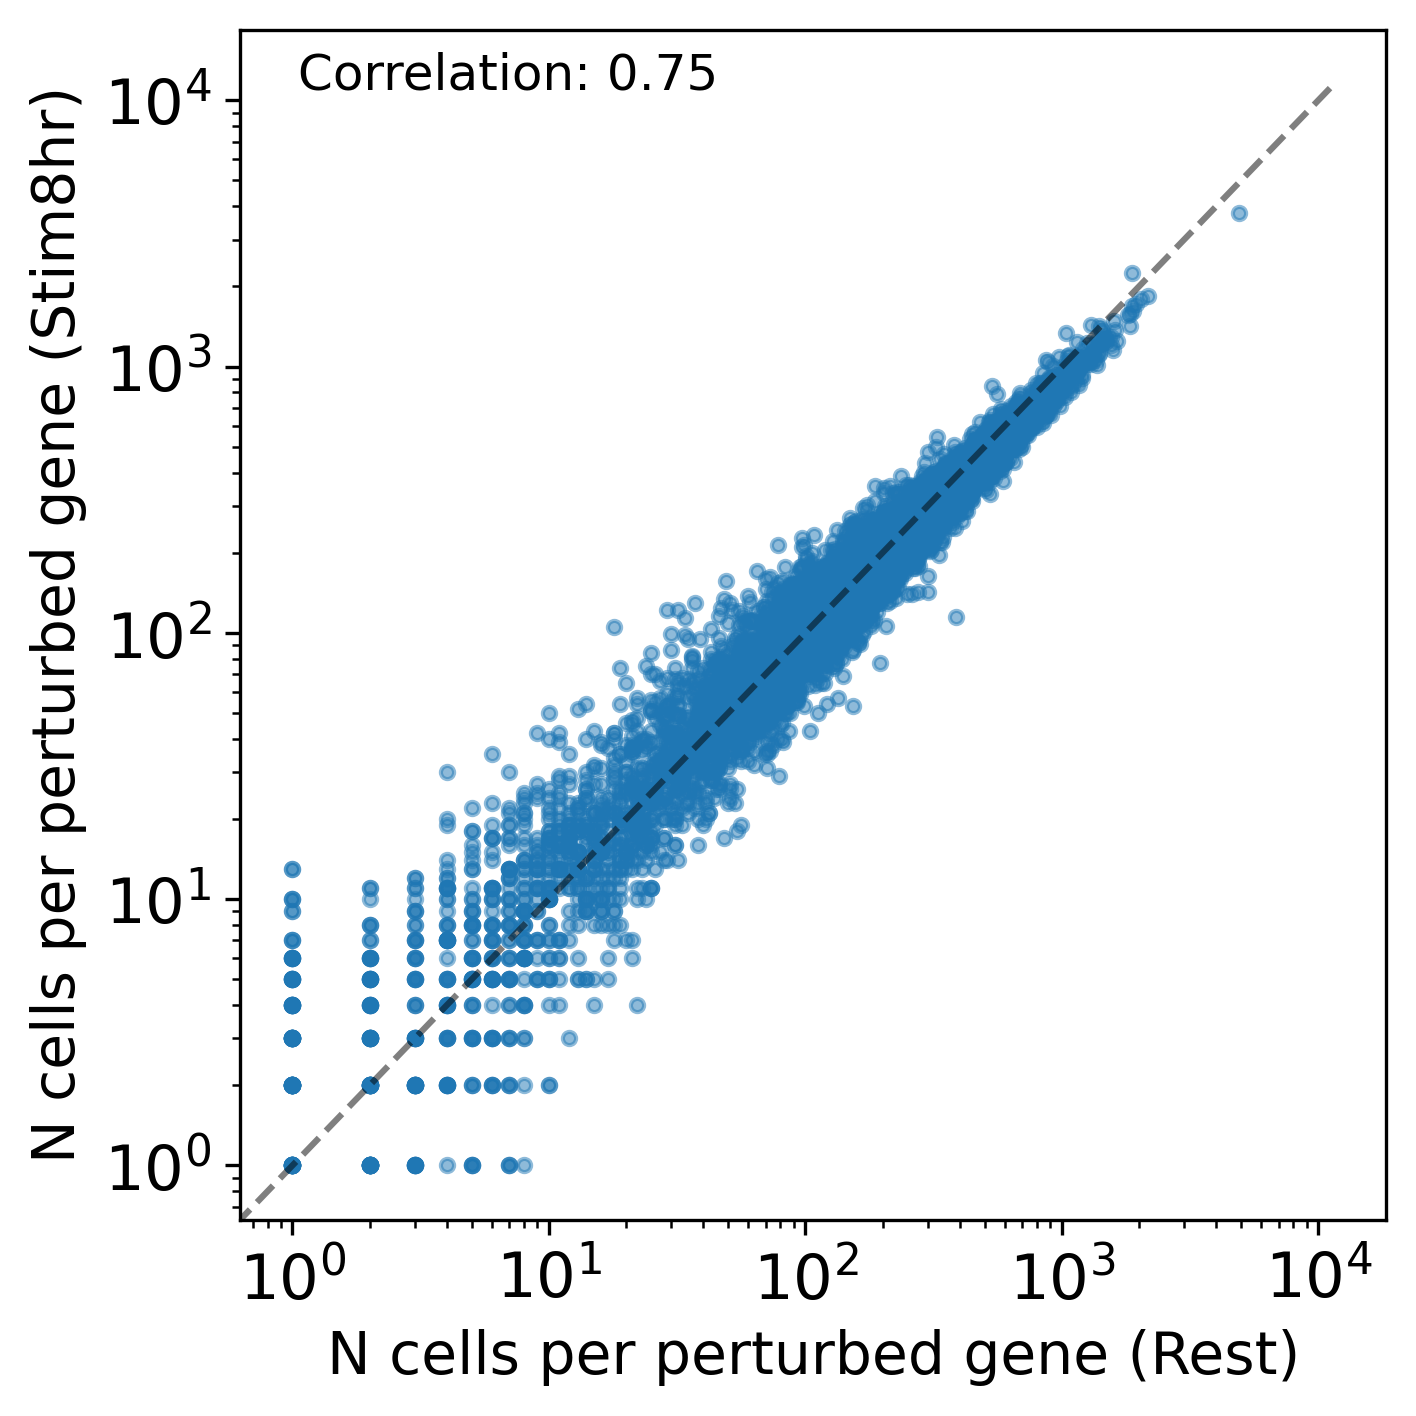

In [26]:
# Create a scatter plot comparing cell counts between conditions
plt.figure(figsize=(5, 5))
plt.scatter(all_genes_df[all_genes_df['culture_condition'] == 'Rest']['n_cells'],
           all_genes_df[all_genes_df['culture_condition'] == 'Stim8hr']['n_cells'],
           alpha=0.5, s=10)

# Add diagonal line
max_val = max(all_genes_df['n_cells'].max(), all_genes_df['n_cells'].max())
plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)

plt.xlabel('N cells per perturbed gene (Rest)', fontsize=14)
plt.ylabel('N cells per perturbed gene (Stim8hr)', fontsize=14)

# Add correlation coefficient
corr = all_genes_df.pivot(columns='culture_condition', 
                         index='perturbed_gene_name', 
                         values='n_cells').corr().iloc[0,1]
plt.text(0.05, 0.95, f'Correlation: {corr:.2f}', 
         transform=plt.gca().transAxes, fontsize=12)
plt.xscale('log')
plt.yscale('log')

plt.tight_layout()

## Check sgRNA assignments

In [24]:
from tqdm.notebook import tqdm

Processing Rest samples:   0%|          | 0/5 [00:00<?, ?it/s]

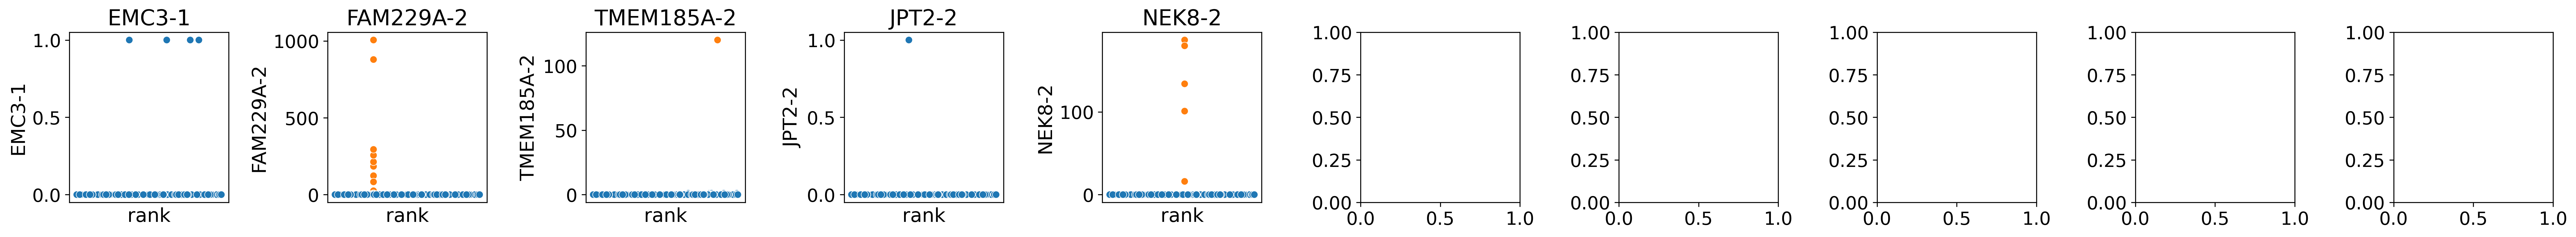

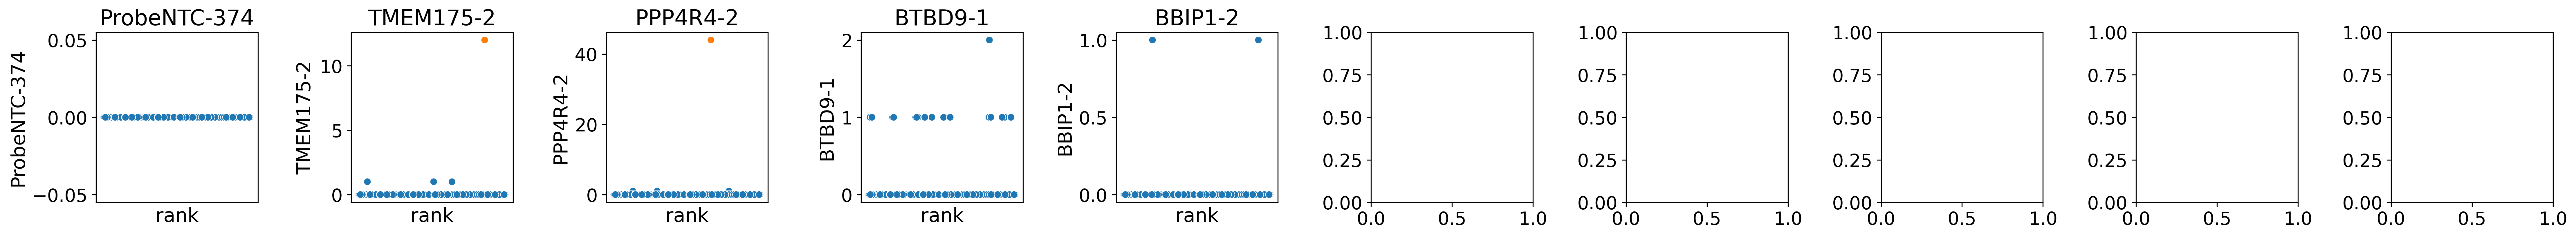

In [25]:
for sample_id in tqdm(np.random.choice(all_samples, 5), desc="Processing Rest samples"):
    # f = f'{datadir}/tmp/{sample_id}.scRNA.postQC.h5ad'
    f = f'{datadir}/{sample_id}.sgRNA.h5ad'
    try:
        adata = ad.read_h5ad(f)
        # adata.X = adata.X.compute()
        # adata.obs = adata.obs.to_dataframe()
        # adata.var = adata.var.to_dataframe()
        assignment = sgrna_assignments2adata(adata, datadir, sgrna_library_metadata=sgrna_library_metadata, sample_id=sample_id)
        # Create figure with one row and 10 columns
        fig, axes = plt.subplots(1, 10, figsize=(30, 3))
        
        # Plot each gene in its own subplot
        for i, g in enumerate(np.random.choice(adata.var_names, 5)):
            check_df = sc.get.obs_df(adata[adata.obs.guide_id != 'multi_sgRNA'], ['guide_id', g])
            check_df['assigned_guide'] = check_df['guide_id'] == g
            check_df['rank'] = check_df.rank()['guide_id']
            
            sns.scatterplot(data=check_df, x='rank', y=g, hue='assigned_guide', ax=axes[i], legend=False)
            axes[i].set_xticks([])
            axes[i].set_title(g)
            
        plt.tight_layout()
        plt.show()
    except:
        continue

In [43]:
# for sample_id in tqdm(all_samples[0:10], desc="Processing samples"):
#     f = f'{datadir}/tmp/{sample_id}.scRNA.postQC.h5ad'
#     # f = f'{datadir}/{sample_id}.sgRNA.h5ad'
#     try:
#         adata = ad.experimental.read_lazy(f)
#         # adata.X = adata.X.compute()
#         # adata.obs = adata.obs.to_dataframe()
#         # adata.var = adata.var.to_dataframe()

#         adata.X = adata.X.compute()
#         adata.obs = adata.obs.to_dataframe()
#         adata.var = adata.var.to_dataframe()
#         sc.pp.normalize_total(adata)
#         sc.pp.log1p(adata)
#         adata.var_names = adata.var['gene_name'].copy()

#         # Spot check knock-downs
#         expr_genes = adata.var_names[adata.var['mean_counts'] > 0.1]
#         seen_perturbs = adata.obs['perturbed_gene_name'].value_counts()[1:500].index.tolist()

#         gs = np.random.choice(np.intersect1d(expr_genes, seen_perturbs), 5).tolist()

#         sc.pl.violin(
#             adata[adata.obs['perturbed_gene_name'].isin(list(gs) + ['NTC'])],
#             gs, groupby='perturbed_gene_name')
#     except FileNotFoundError:
#         continue